In [27]:
import pysam as ps
import numpy as np
import collections
import matplotlib.pyplot as plt
from numpy.core.defchararray import array, center
import pysam as ps
import numpy as np
from collections import defaultdict
from scipy.ndimage.measurements import label, standard_deviation
from scipy.stats.mstats_basic import kstest, normaltest
from sklearn.cluster import KMeans
import sys
from scipy.signal import savgol_filter
import math
from subprocess import call
import os.path
from utils import Gene, TSS, Point
from scipy import stats
from sklearn import svm
import sympy
import math
from math import e
import random
from keras import Model
from keras.models import load_model
import numpy as np
import os
import pandas as pd

In [28]:
dic = {
    'gene':'./data/gene/GRCh37.gene.bed',
    'non_gene':'./data/gene/non_gene.bed',
    'non_gene_4':'./data/gene/non_gene_4.bed',
    'non_gene_2':'./data/gene/non_gene_2.bed',
    'fasta':'/home/jiay/Desktop/hg19/hg19.fa',
    'bam1':'./data/051.bam',
    'bam2':'./data/051_2.bam',
    'bam3':'./data/051_3.bam',
    'bam123':'./data/051_123.bam',
    'bam4':'./data/051_4.bam',
    'bam5':'./data/051_5.bam',
    'TSS_low':'./data/gene/low_expressed.bed',
    'TSS_HK':'./data/gene/HK.bed',
    'TSS_silent':'./data/gene/silent_gene_TSS.bed',
    'ATAC_hema_1':'./data/gene/ATAC_hema_1.bed',
    'ATAC_hema_2':'./data/gene/ATAC_hema_2.bed',
    'ATAC_Bcell':'./data/gene/ATAC_Bcell.bed',
    'ATAC_Bcell':'./data/gene/ATAC_Bcell.bed',
    'ATAC_Brain':'./data/gene/ATAC_Brain.bed'
    }
TSS_HK = []
with open(dic['TSS_HK'],'r') as f:
    for line in f:
        ll = line.strip().split('\t')
        if ll[0] in ['1','2','3']:
            TSS_HK.append(TSS(ll[0], int(int(ll[1])+1000)))
# with open(dic['ATAC_hema_1'],'r') as f:
#     for line in f:
#         ll = line.strip().split('\t')
#         TSS_HK.append(TSS(ll[0], int((int(ll[1])+int(ll[2]))/2)))
        


TSS_NonGene = []
with open(dic['non_gene'],'r') as f:
    for line in f:
        ll = line.strip().split('\t')
        TSS_NonGene.append(TSS(ll[0], int(ll[1])+int(1000)))
# with open(dic['ATAC_Bcell'],'r') as f:
#     for line in f:
#         ll = line.strip().split('\t')
#         if ll[0] in ['1','2','3'] and ll[2] == '0':
#             TSS_NonGene.append(TSS(ll[0],int(ll[1])))

bamfile = ps.AlignmentFile(dic['bam123'],'rb')

TSS_NonGene = TSS_NonGene[:len(TSS_HK)]

TSSes_x = TSS_HK + TSS_NonGene
TSSes_y = [1]*len(TSS_HK) + [0]*len(TSS_NonGene)
perm = random.sample(range(len(TSSes_x)),len(TSSes_x))
TSSes_x = np.array(TSSes_x)
TSSes_y = np.array(TSSes_y)
TSSes_x = TSSes_x[perm[:len(perm)]]
TSSes_y = TSSes_y[perm[:len(perm)]]
labels = TSSes_y
up = 1000
down = 1000

In [53]:
#lstm
feature_matrix = []
for j, tss in enumerate(TSSes_x):
    chrom = tss.chrom
    start = tss.pos - up
    end = tss.pos + down
    up_end = np.zeros(up+down, dtype= int)
    down_end = np.zeros(up+down, dtype= int)
    long = np.zeros(up+down, dtype= int)
    short = np.zeros(up+down, dtype= int)
    cov = np.zeros(up+down, dtype= int)
    wps = np.zeros(up+down, dtype=float)
    win = 120
    for r in bamfile.fetch(chrom[-1], start-500, end + 500):
        if (not r.is_reverse) and (not r.is_unmapped) and (not r.mate_is_unmapped) and r.mate_is_reverse:
            if r.reference_start + abs(r.isize) < start:
                continue
            if r.reference_start >= end:
                continue
            ss = r.reference_start - start
            ee = r.reference_start - start + abs(r.isize)
            if ss >= 0:
                up_end[ss] += 1
            else:
                ss = 0
            if ee < end - start:
                down_end[ee] += 1
            else:
                ee = end - start
            for i in range(ss, ee):
                cov[i] += 1
            if 200 >= abs(r.isize) > 130:
                for i in range(ss, ee):
                    long[i] += 1
            if abs(r.isize) <= 130:
                for i in range(ss, ee):
                    short[i] += 1
            # wps_total
            region1 = int(max(0, ss + win/2))
            region2 = int(min(ee - win/2, end-start))
            i = region1
            while i < region2:
                wps[i] += 1
                i = i+1
            # wps_part
            region1 = int(max(0, ss - win/2))
            region2 = int(min(end-start, ss + win/2))
            i = region1
            while i < region2:
                wps[i] -= 1
                i = i + 1
            # wps_part
            region1 = int(max(ee - win/2, 0))
            region2 = int(min(ee + win/2, end-start))
            i = region1
            while i < region2:
                wps[i] -= 1
                i = i+1
    k = 0
    win = 10
    feature_win = np.zeros((int((up+down)/win), 4), dtype= int)
    while k < (up+down)/win:
        ss = k * win
        ee = k * win + win
        ff = []
        ff.append(int(round(np.mean(cov[ss:ee]))))
        ff.append(int(round(np.mean(long[ss:ee]-short[ss:ee]))))
        ff.append(int(round(np.sum(abs(up_end[ss:ee]-down_end[ss:ee])))))
        ff.append(int(round(np.mean(wps[ss:ee]))))
        feature_win[k] = np.array(ff)
        k = k + 1
    feature_matrix.append(feature_win)
feature_matrix = np.array(feature_matrix)

lstm_x = []
for mat in feature_matrix:
    lstm_x.append(mat)
lstm_x = np.array(lstm_x)


In [54]:
train_lstm_x = lstm_x[:int(len(lstm_x)*0.8)]
train_y = labels[:int(len(labels)*0.8)]
test_lstm_x = lstm_x[int(len(lstm_x)*0.8):]
test_y = labels[int(len(labels)*0.8):]

In [55]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

def focal_loss(y_true, y_pred):
   gamma = 1.0
   alpha = 0.5
   pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
   pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
   return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))

model = keras.Sequential()
model.add(keras.layers.Convolution1D(filters=128, kernel_size=2, activation='relu',strides=1,padding='same',input_shape=(lstm_x.shape[1], lstm_x.shape[2])))
model.add(keras.layers.MaxPooling1D(pool_size=2, strides=2))
model.add(keras.layers.Convolution1D(filters=64, kernel_size=2, activation='relu',strides=1,padding='same'))
model.add(keras.layers.MaxPooling1D(pool_size=2, strides=2))
model.add(keras.layers.Convolution1D(filters=32, kernel_size=2, activation='relu',strides=1,padding='same'))
model.add(keras.layers.MaxPooling1D(pool_size=2, strides=2))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(25, return_sequences=True)))
model.add(keras.layers.Convolution1D(filters=64, kernel_size=2, activation='relu',strides=1,padding='same'))
model.add(keras.layers.MaxPooling1D(pool_size=2, strides=2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(300, activation='relu', kernel_regularizer=None, bias_regularizer=None))
model.add(keras.layers.Dropout(0.2))
# model.add(keras.layers.Dense(150, activation='relu', kernel_regularizer=None, bias_regularizer=None))
# model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(16, activation='relu', kernel_regularizer=None, bias_regularizer=None))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(2, activation='sigmoid', kernel_regularizer=None, bias_regularizer=None,name='ff'))
model.add(keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=None, bias_regularizer=None,name='gg'))

# print(model.summary())

adam = keras.optimizers.Adam(lr=1e-4)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
# model.compile(optimizer=adam, loss=focal_loss, metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(train_lstm_x, train_y, epochs=300, batch_size=128, validation_split=0.1,
                        callbacks=[EarlyStopping(patience=10), ModelCheckpoint(filepath='./' + 'lstm.h5', save_best_only=True)],
                        shuffle=True, verbose=2)
loss, accuracy = model.evaluate(test_lstm_x, test_y)
print("loss=",loss,"acc=",accuracy)

Epoch 1/300
10/10 - 4s - loss: 0.7139 - accuracy: 0.4784 - val_loss: 0.6955 - val_accuracy: 0.4962
Epoch 2/300
10/10 - 0s - loss: 0.6960 - accuracy: 0.4784 - val_loss: 0.6812 - val_accuracy: 0.4962
Epoch 3/300
10/10 - 0s - loss: 0.6837 - accuracy: 0.4784 - val_loss: 0.6672 - val_accuracy: 0.4962
Epoch 4/300
10/10 - 1s - loss: 0.6695 - accuracy: 0.4784 - val_loss: 0.6469 - val_accuracy: 0.4962
Epoch 5/300
10/10 - 1s - loss: 0.6496 - accuracy: 0.4784 - val_loss: 0.6260 - val_accuracy: 0.4962
Epoch 6/300
10/10 - 0s - loss: 0.6281 - accuracy: 0.4784 - val_loss: 0.6003 - val_accuracy: 0.4962
Epoch 7/300
10/10 - 0s - loss: 0.6090 - accuracy: 0.4784 - val_loss: 0.5815 - val_accuracy: 0.4962
Epoch 8/300
10/10 - 0s - loss: 0.5949 - accuracy: 0.5030 - val_loss: 0.5689 - val_accuracy: 0.4962
Epoch 9/300
10/10 - 0s - loss: 0.5813 - accuracy: 0.5835 - val_loss: 0.5614 - val_accuracy: 0.6489
Epoch 10/300
10/10 - 0s - loss: 0.5721 - accuracy: 0.6930 - val_loss: 0.5565 - val_accuracy: 0.7710
Epoch 11/

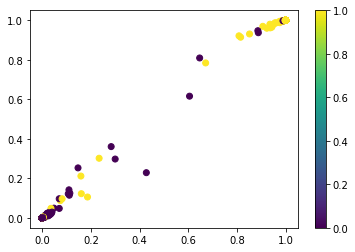

In [56]:
pre = Model(inputs = model.input, outputs=model.get_layer('ff').output).predict(train_lstm_x)
plt.scatter(pre[:, 0], pre[:, 1], c=train_y)
plt.colorbar()
plt.show()

In [36]:
c_1 = []
c_0 = []
for i,p in enumerate(pre):
    if train_y[i] == 1 and p[0] > 0.2:
        c_0.append(i)
    elif train_y[i] == 0 and p[0] > 0.2:
        c_1.append(i)
print(len(c_1))

7
